# CNN User Guide

Because creating a fully-fledged CNN would require many more samples than are at our disposal, a highly simplified 3-class CNN was created to explore how a CNN classification tool might be an effective and more wholeistic avenue for determining adulteration within maple syrups and juices. As a disclaimer: this CNN is simply a proof of concept and not intended to be a rigorous demonstration. It has problems with overfitting to the small sample size and (in part due to this) is sensitive to class imbalances which can tend it at times to solely classify into the majority class. 

#### Before Any Coding: 

The first step is to have Python 3 and the most recent relevant software downloaded to your computer. None of this will run on Python 2. You can see what versions of packages you have by typing "pip list" into "Command Prompt" or any command line interface. Download a relevant package, X, by typing "pip install X" or "conda install X" if you are using Anaconda. 

Once you have downloaded the necessary packages, you must pick an IDE, an integrated development environment, which is where you will write, run, and de-bug your code. There are many free ones to choose from, to name a few: Jupyter, Spyder, Atom, Sublime. A simple Google search will help you pick one out. Download it. 

Now you are ready to load your libraries and begin running some code. When you see, for example, "import numpy as np", it means you are importing the numpy library as the nickname, "np." This means that when you want to use something from numpy, you need only to refer to it as "np." When you see, "from tensorflow import keras," it means that you are importing a sublibrary of tensorflow, "keras."

After importing all the needed libraries, use "splitfolders" to create a more random train/validation/test split of 70/15/15 percents respectively. The validation set serves as a benchmark for the training set to validate with at the end of each epoch. Validation is not to be confused with the testing set as the model does "see" the validation set throughout training and before final model evaluation, but never encounters testing data until after having already been fit. 

"splitfolders" is used because, as of yet, "ImageDataGenerator()" has no tri-split option. To prepare to use "ImageDataGenerator()" and "flow_from_directory", establish separate folders to refer to your bulk (unsplit) data and your data that has been split into training, testing, and validation. The contents of the bulk and split folders will be the same but configured differently into sub-folders for the model to pull from.

The folder set-up looked something like this: 

[Click for Sample Folder Set-Up](https://drive.google.com/file/d/1NMLOxguM6qOvepJrEaYkeqkPZXg7-7Xz/view?usp=share_link)

As an example to start off and get a feel for the folder structure, you can access a some datasets [here](https://drive.google.com/drive/folders/1TJqzveU8Fu7GMHdAJEBOedyTA5VgJWHL?usp=share_link). Simply download a copy of the folders to your own drive for the next steps. 

Firstly, you will have to manually install "split-folders" into the CoLab space because it does not come preloaded. This is achieved by simply typing "!pip install split-folders." 

Next, you will mount (connect) your entire drive, where your copy of the CNN dataset lives. "drive.mount(/content/drive/)" will cause an authorization window to appear, where you will log-in to approve the connection. Once you have completed this, you may click the folder icon in the menu bar on the upper left-hand side of the screen. Here you will see a list of all the files within "MyDrive." You should navigate to wherever your stored you data.

[Click here for a visual on what your directory should look like.](https://drive.google.com/file/d/1KCAa5WsioKoJhJ_pLUnq6Jl-NVSluYrk/view?usp=sharing)

Once you have found it, you must upload the "bulk" and "split" folders individually into the notebook. Right click on the folders within your directory, and click "Copy path."

You can the paste the paths for your "bulk" and "split" folders into "input_folder" and "output_folder" respectively. When we call "splitfolders" it will create three additional folders within our assigned output folder: "train", "test", and "val". You will note that we assign the percent of the data in each of the three folders with the "ratio" argument. We set a random seed with the "seed" argument, so that the user can reproduce the same results by assigning the same seed. 

Now, we specifically store the paths of those newly created folders to, "train_data_dir", "test_data_dir" and "val_data_dir" in the same way as we just did. __It is important to note__, that if you re-run the model, or run it multiple times, you must manually delete __<font color='red'>all</font>__ contents of the "output_folder," such that the "output_folder" in your directory is empty. The reason for this is that you will be re-running "splitfolders," and you want it to output into a empty folder to avoid duplication of images. 

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import scipy as sp
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
import math
import sklearn
from sklearn import metrics
import splitfolders 

input_folder = r"C:\Users\maiaz\Desktop\Dark Auto Sets\3 Class\3 Class Bulk"
output_folder= r"C:\Users\maiaz\Desktop\Dark Auto Sets\3 Class Split"

splitfolders.ratio(input_folder, output= output_folder, ratio = (0.7, 0.15, 0.15))

train_data_dir = r"C:\Users\maiaz\Desktop\Dark Auto Sets\3 Class Split\train"
test_data_dir = r"C:\Users\maiaz\Desktop\Dark Auto Sets\3 Class Split\test"
val_data_dir = r"C:\Users\maiaz\Desktop\Dark Auto Sets\3 Class Split\val"

In image width and batch size were set, corresponding to the 86x86 pixel images created with "CNN Preprosessing." The parameters of "ImageDataGenerator" were set with the 3-channel images being rescaled. Width, height, and zoom shifts of 5% were added, and horizontal image reflections were allowed. This discourages network overfitting and simulates having more data than actually available. We do not apply any of these transformations (except for rescaling) to the "test_datagen" because there is not need to simulate more data with our testing set. After all, the model encounters this data __only__ once. 

In [4]:
img_width, img_height = 86, 86
batch_size = 40

train_datagen = ImageDataGenerator(
rescale=1./255,
width_shift_range=.05,
height_shift_range=.05,
zoom_range=0.05,
horizontal_flip=True)

test_datagen = ImageDataGenerator(
rescale=1./255)

Here the three datasets are actually established. The train and validation sets have shuffling enabled, while the test does not. This is because we need to preserve the order of the testing set in order to properly create our confusion matrix at the end. The class_mode is set to "categorical" because we will use "CategoricalCrossEntropy", which only takes categorical class labels, as the model loss function.

In [5]:
train_ds = train_datagen.flow_from_directory(
train_data_dir,
shuffle=True,
target_size=(img_width, img_height),
batch_size=batch_size,
class_mode='categorical')

valid_ds = train_datagen.flow_from_directory(
val_data_dir,
shuffle=True,
target_size=(img_width, img_height),
batch_size=batch_size,
class_mode='categorical')

test_ds= test_datagen.flow_from_directory(
test_data_dir,
shuffle=False,
target_size=(img_width, img_height),
batch_size=batch_size,
class_mode='categorical')


Found 213 images belonging to 3 classes.
Found 44 images belonging to 3 classes.
Found 49 images belonging to 3 classes.


Finally, we create and train the model. The number of hidden layers were chosen by trial and error and probably don't reflect what the architecture of a "final" model would be. The learning rate was brought down to .0001 to improve accuracy, and as with the ANN, "EarlyStopping" was used to reduce overtraining the model (which is also why the number of epochs is set to 1000). I encourage you to examine the Keras API documentation to discover more specifics about the elements used in model building. Each model may have different needs.

That being said, here are some brief definitions to get you started.

#### “Sequential Model”
- Top-down stack of layers where each layer has one input and one output tensor.
- Basic model suitable for most classification problems

#### “ReLu”
- Short for Rectified Linear Activation Function
- Transforms the summed input weight into the output as such:
 - If input is positive: It will output the original input
 - If input is negative or 0: It will output 0
- Benefits: 
 - Computationally cheap
 - Acts linearly for half the data, so it’s desirable for optimizing NNs
 
#### “Softmax”
 - Elements of the output are in the range of (0,1) summing to 1
 - Results are probability distribution for multiclass classification.
 
 
#### Optimizer = “Adam”
- Optimizer changes weights and ANN attributes according the “Adam” algorithm
- Adam stands for Adaptive Moment Estimation
- Is an extension of stochastic gradient descent and an update of RMSProp
 - The algorithm calculates an exponential moving average of the gradient and the squared gradient, and the parameters beta1 and beta2 control the decay rates of these moving averages.
- Also standard recommended by tensorflow

#### Loss = “CategoricalCrossentropy” 
- Takes outputs probabilities from Softmax and measures their distance from the truth values. 
- Goal is for this distance to be as small as possible (ie: minimizing the loss)
- Penalizes the probability based on how far it is from truth using a logarithmic scale, so closer to 0 means less penalty and closer to 1 means greater penalty.

#### “Param #”
- Represents the number of learnable elements in each layer. It can be written as: 

    (Output_Shape) x (Output_Shape_of_Previous_Layer) + 1
    
    Where 1 is a bias neuron added to provide the model added flexibility to better fit the data.

#### "Epochs" 
- number of training runs

#### "Units" 
- Another word for nodes/neurons 
- Contains one activation input and output. 
- In the case of the ANN for maple syrups, because there are so many trainable parameters, the number of nodes decreases with each layer. 

#### "EarlyStopping"
- Designed to prevent before overfitting gets out of control
- Will stop training when a certain set criteria has been met. 
- Example:
 - ‘monitor=’val_loss’’ means that the criteria is the validation loss.
 - ‘patience = 25’ indicates that if the monitor doesn’t improve withing 25 epochs, training will stop. 

#### "batch_size"
- The number of samples trained in each epoch.

#### "Conv2D"
- A 2D convolutional layer, ideal for spacial convolution over images. It outputs what is known as a feature map.
 - To name a few of its arguments: 
 
    #### "kernel_size"
   - Also known as a convolution matrix, the kernel_size determines the size of the filter that will pass over the image from left to right and top to bottom, calculating a "convolution product" which is intended to extract the most important features of an input image. So, (3, 3) means that the kernel is 3x3 pixels.
   
   #### "strides"
   - This is the number of pixel steps that the kernel moves up and down when calculating its "convolution product." It is automatically set to (1, 1) meaning it moves in 1 pixel increments to the right and down (at the end of each row).
   
   #### "input_shape"
   - This is only needed for the first "Conv2D" layer if there are multiple "Conv2D" layers. It simply describes the image's imput shape. The first two dimensions are the image width and height, and the third dimension denotes how many channels the image has. RBG images have 3 channels, BW images have only 1. 

#### “Dense Layer”
- A layer that is deeply connected to its previous layer
- output = activation(dot(input, kernel) + bias)
 - activation is the activation function defined
 - dot is the numpy dot product
 - input is input data
 - kernel is the weight data for that layer.
 - bias is the bias value added

#### "learning_rate"
- The learning rate regulates how much the NN updates its weights based on the loss calculated. 
- Represents the speed at which the model learns.
- A lower learning rate can ensure that we don't miss any local minima, but can mean that the model takes longer to converge. 

#### "Flatten()"
- Reduces the dimensions of the input so it can be fed into a Dense layer. 

#### "MaxPooling2D"
- This is an operation that calculates the maximum value for areas of a feature map (output of a Conv2D layer), and uses that to create a smaller representative feature map. It is found right after convolutional layers. 

In [6]:
#THE MODEL
cnn = Sequential()

cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=(img_width,img_height,3)))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Flatten())

cnn.add(Dense(32, activation='relu'))
cnn.add(Dense(3, activation='softmax'))

optimizer = keras.optimizers.Adam(learning_rate=.0001)
cnn.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=optimizer,
              metrics=['accuracy'])
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

epochs=1000

history = cnn.fit(
  train_ds,
  validation_data=valid_ds,
  steps_per_epoch=math.ceil(len(train_ds) / batch_size),
  epochs=epochs,
  callbacks=[es])

Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 1.0975 - accuracy: 0.3000 - val_loss: 1.0716 - val_accuracy: 0.5455
Epoch 2/1000
1/1 [==============================] - 0s 303ms/step - loss: 1.0931 - accuracy: 0.4615 - val_loss: 1.0743 - val_accuracy: 0.4091
Epoch 3/1000
1/1 [==============================] - 0s 399ms/step - loss: 1.0470 - accuracy: 0.5000 - val_loss: 1.0488 - val_accuracy: 0.4773
Epoch 4/1000
1/1 [==============================] - 0s 342ms/step - loss: 1.0117 - accuracy: 0.5750 - val_loss: 1.0417 - val_accuracy: 0.5000
Epoch 5/1000
1/1 [==============================] - 0s 348ms/step - loss: 1.0690 - accuracy: 0.4000 - val_loss: 1.0134 - val_accuracy: 0.4545
Epoch 6/1000
1/1 [==============================] - 0s 313ms/step - loss: 0.9348 - accuracy: 0.5750 - val_loss: 0.9922 - val_accuracy: 0.5227
Epoch 7/1000
1/1 [==============================] - 0s 339ms/step - loss: 0.9097 - accuracy: 0.6250 - val_loss: 0.9662 - val_accuracy: 0.5682
Epoch 8/1

1/1 [==============================] - 0s 273ms/step - loss: 0.6359 - accuracy: 0.7000 - val_loss: 0.4416 - val_accuracy: 0.8182
Epoch 116/1000
1/1 [==============================] - 0s 291ms/step - loss: 0.4244 - accuracy: 0.7750 - val_loss: 0.4409 - val_accuracy: 0.8182
Epoch 117/1000
1/1 [==============================] - 0s 270ms/step - loss: 0.3928 - accuracy: 0.8000 - val_loss: 0.4635 - val_accuracy: 0.7273
Epoch 118/1000
1/1 [==============================] - 0s 293ms/step - loss: 0.4934 - accuracy: 0.8000 - val_loss: 0.4659 - val_accuracy: 0.8182
Epoch 119/1000
1/1 [==============================] - 0s 270ms/step - loss: 0.4661 - accuracy: 0.7750 - val_loss: 0.4721 - val_accuracy: 0.8182
Epoch 120/1000
1/1 [==============================] - 0s 276ms/step - loss: 0.4837 - accuracy: 0.8000 - val_loss: 0.4973 - val_accuracy: 0.7045
Epoch 121/1000
1/1 [==============================] - 0s 275ms/step - loss: 0.4125 - accuracy: 0.7750 - val_loss: 0.4697 - val_accuracy: 0.7955
Epoch 1

Epoch 172/1000
1/1 [==============================] - 0s 274ms/step - loss: 0.6681 - accuracy: 0.7750 - val_loss: 0.4459 - val_accuracy: 0.7955
Epoch 173/1000
1/1 [==============================] - 0s 194ms/step - loss: 0.8792 - accuracy: 0.6923 - val_loss: 0.4832 - val_accuracy: 0.7500
Epoch 174/1000
1/1 [==============================] - 0s 266ms/step - loss: 0.4698 - accuracy: 0.6750 - val_loss: 0.4550 - val_accuracy: 0.7727
Epoch 175/1000
1/1 [==============================] - 0s 270ms/step - loss: 0.4580 - accuracy: 0.7250 - val_loss: 0.4705 - val_accuracy: 0.8182
Epoch 176/1000
1/1 [==============================] - 0s 267ms/step - loss: 0.4495 - accuracy: 0.8000 - val_loss: 0.4750 - val_accuracy: 0.8182
Epoch 177/1000
1/1 [==============================] - 0s 273ms/step - loss: 0.5442 - accuracy: 0.7500 - val_loss: 0.4209 - val_accuracy: 0.8636
Epoch 178/1000
1/1 [==============================] - 0s 272ms/step - loss: 0.5495 - accuracy: 0.7250 - val_loss: 0.4735 - val_accuracy:

We plot the loss functions and show the weighted accuracy and loss for the training, validation, and test sets. Here you can see that the training and validation loss fluctuated greatly before bottoming out. This is likely due to the small dataset available.

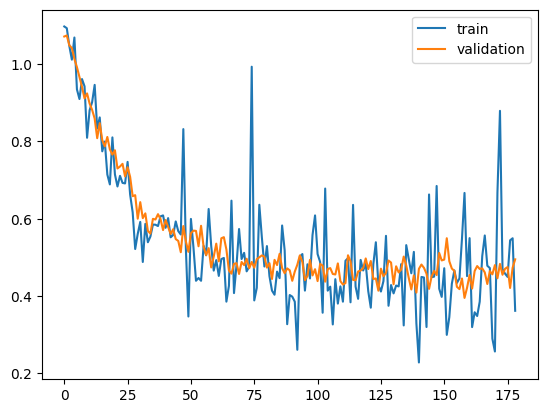

2/2 [==============================] - 0s 17ms/step - loss: 0.4845 - accuracy: 0.7727
[0.48454543948173523, 0.7727272510528564]
6/6 [==============================] - 0s 68ms/step - loss: 0.4814 - accuracy: 0.7793
[0.48144596815109253, 0.7793427109718323]
2/2 [==============================] - 0s 4ms/step - loss: 0.4983 - accuracy: 0.8163
[0.49829334020614624, 0.8163265585899353]


In [8]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

print(cnn.evaluate(valid_ds))
print(cnn.evaluate(train_ds))
print(cnn.evaluate(test_ds))

Here we create a confusion matrix and classification report to show which classes performed better (rather than an average) which can be misleading. 

2/2 [==============================] - 0s 18ms/step
              precision    recall  f1-score   support

 10 and over       1.00      0.56      0.72        16
 5 and under       0.64      1.00      0.78        16
        Pure       1.00      0.88      0.94        17

    accuracy                           0.82        49
   macro avg       0.88      0.81      0.81        49
weighted avg       0.88      0.82      0.82        49



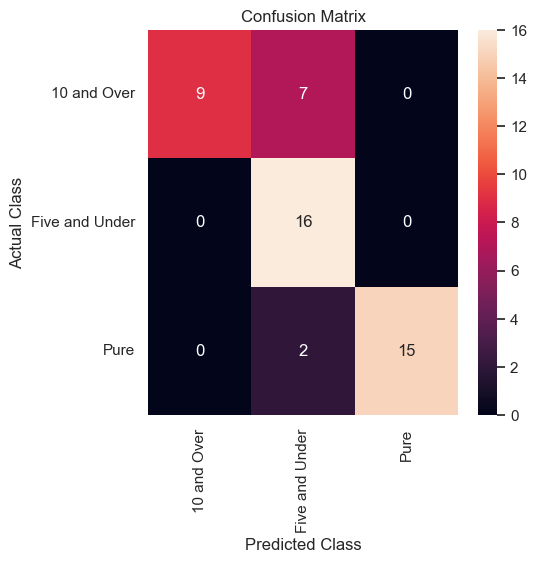

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

test_steps_per_epoch = np.math.ceil(test_ds.samples / test_ds.batch_size)
predictions = cnn.predict(test_ds, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions,axis=1)
true_classes = test_ds.classes
class_labels = list(test_ds.class_indices.keys())   
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)  

X_labels= ["10 and Over", "Five and Under", "Pure"]
#X_labels= ["Adulterated", "Pure"]
cm = confusion_matrix(true_classes, predicted_classes)
sns.set(font_scale=1) # Adjust to fit
fig, ax = plt.subplots(figsize=(5,5))  
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Class')
ax.set_ylabel('Actual Class')
ax.xaxis.set_ticklabels(X_labels);
ax.tick_params(axis='x', rotation=90)
ax.tick_params(axis='y', rotation=360)
ax.yaxis.set_ticklabels(X_labels);

The following shows feature maps for a sample image in the training set. The feature map shows that the CNN is primarily learning from the actual EEMs (or lack thereof) rather than unrelated noise and artifacts within the images. Note that the code for feature visualization is __not__ my own and was pulled from user [arshren's github](https://github.com/arshren/Feature-Visualization). You can pick __any__ image from your "Split" dataset (in "train", "test", or "val") and copy the path of that png. Then, paste that path into "img_path" below. 

1/1 [==============================] - 0s 62ms/step
(1, 42, 42, 32)
(1, 56448)
(1, 32)
(1, 3)


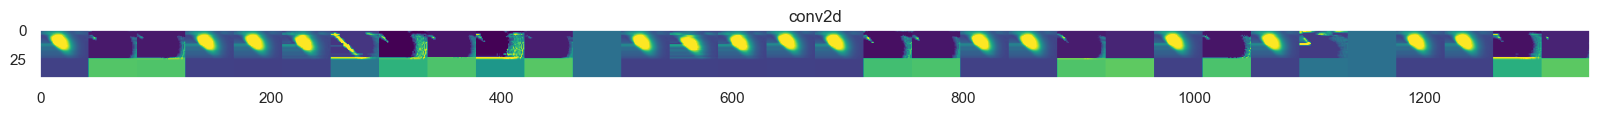

In [19]:
#Filter shape
for layer in cnn.layers:
    if 'conv' not in layer.name:
        continue    
    filters , bias = layer.get_weights()

#size of output
for i in range(len(cnn.layers)):
    layer = cnn.layers[i]
    if 'conv' not in layer.name:
        continue    

#Feature map visualization code from https://github.com/arshren/Feature-Visualization
from tensorflow.keras.models import Model
successive_outputs = [layer.output for layer in cnn.layers[1:]]
visualization_model = Model(inputs = cnn.input, outputs = successive_outputs)
img_path = r"C:\Users\maiaz\Desktop\Dark Auto Sets\3 Class\3 Class Split\test\10 and over\DrMBD5 (3).png"
img = keras.utils.load_img(img_path, target_size=(86, 86))
x = keras.utils.img_to_array(img)                           
x = x.reshape((1,) + x.shape)
x /= 255.0

successive_feature_maps = visualization_model.predict(x)

layer_names = [layer.name for layer in cnn.layers]
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
        
    # Plot Feature maps for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    # Postprocess the feature to be visually palatable
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      if x.std()!= 0: x /= x.std()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      # Tile each filter into a horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )
